In [3]:
import os

train_dir = r"plant_disease_dataset_10_classes_split/plant_disease_dataset_10_classes_split/train"

test_dir = r"plant_disease_dataset_10_classes_split/plant_disease_dataset_10_classes_split/test"

train_classes = os.listdir(train_dir)
test_classes = os.listdir(test_dir)
print(f"Number of classes: {len(train_classes)}")
print(train_classes)

print(f"Number of classes: {len(test_classes)}")
print(test_classes)

Number of classes: 10
['Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_healthy', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_mosaic_virus', 'Tomato__Tomato_YellowLeaf__Curl_Virus']
Number of classes: 10
['Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_healthy', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_mosaic_virus', 'Tomato__Tomato_YellowLeaf__Curl_Virus']


In [4]:
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.02),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = ImageFolder(train_dir, transform=train_transform)

In [5]:
from collections import Counter

train_labels = train_dataset.targets

count_per_classes = Counter(train_labels)

print(f"Total Sample in train_dataset:", len(train_dataset))
print("="*25)

for i, class_name in enumerate(train_dataset.classes):
    print(f"{class_name:<10} -> {count_per_classes[i]}")

Total Sample in train_dataset: 12006
Tomato_Bacterial_spot -> 1595
Tomato_Early_blight -> 750
Tomato_Late_blight -> 1431
Tomato_Leaf_Mold -> 714
Tomato_Septoria_leaf_spot -> 1328
Tomato_Spider_mites_Two_spotted_spider_mite -> 1257
Tomato__Target_Spot -> 1053
Tomato__Tomato_YellowLeaf__Curl_Virus -> 2406
Tomato__Tomato_mosaic_virus -> 279
Tomato_healthy -> 1193


In [6]:
import torch
from torch.utils.data import random_split

torch.manual_seed(32)
full_train_dataset = ImageFolder(train_dir, transform=train_transform)

torch.manual_seed(32)
total_size = len(full_train_dataset)
train_size = int(0.70 * total_size)
val_size = total_size - train_size

train_ds, val_ds = random_split(full_train_dataset, [train_size, val_size])

C:\Users\asus\AppData\Local\Temp\ipykernel_17748\3828551550.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Count', y='Disease', data=df_dist, palette='viridis')


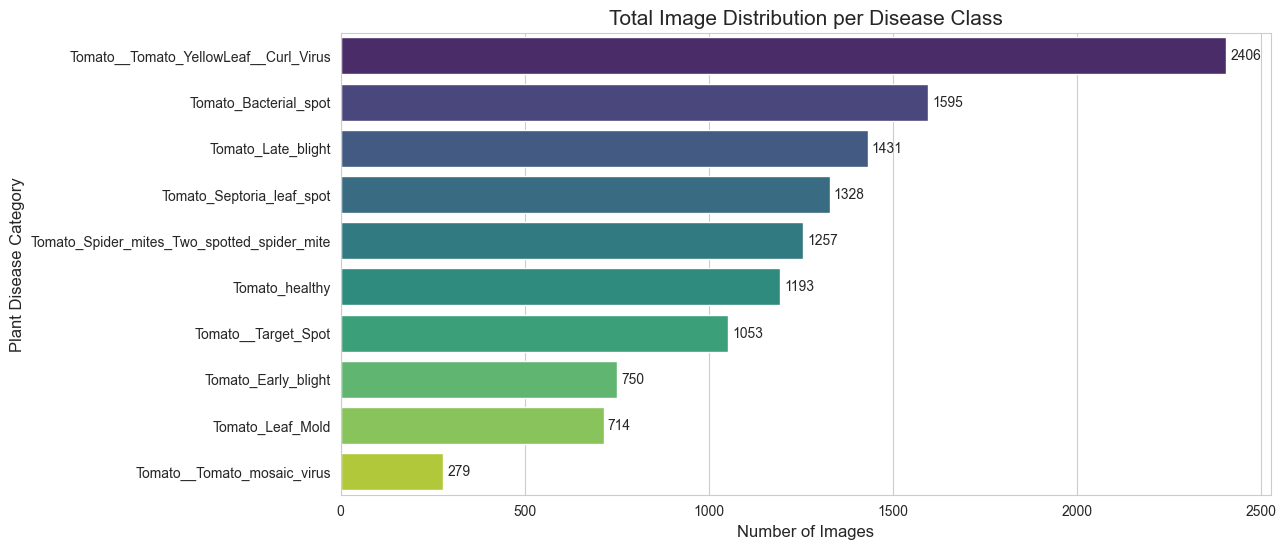

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


df_dist = pd.DataFrame({
    'Disease': full_train_dataset.classes,
    'Count': [count_per_classes[i] for i in range(len(full_train_dataset.classes))]
}).sort_values('Count', ascending=False)

plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")
ax = sns.barplot(x='Count', y='Disease', data=df_dist, palette='viridis')

for i in ax.containers:
    ax.bar_label(i, padding=3)

plt.title("Total Image Distribution per Disease Class", fontsize=15)
plt.xlabel("Number of Images", fontsize=12)
plt.ylabel("Plant Disease Category", fontsize=12)
plt.show()

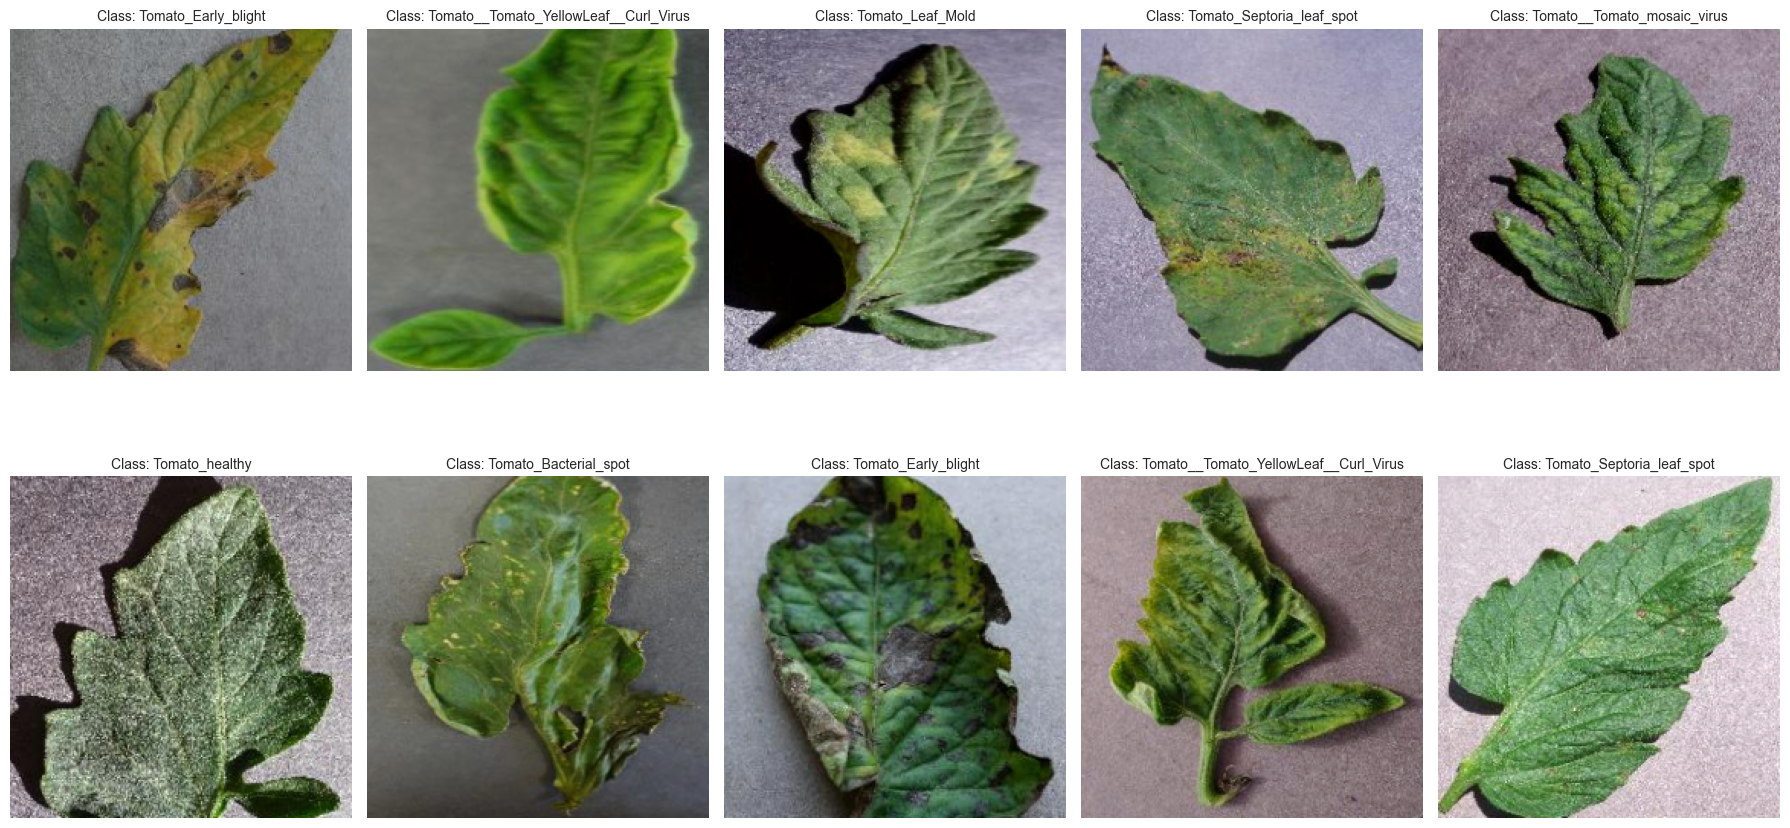

In [18]:
import numpy as np

def show_samples(dataset, num_samples=10):
    plt.figure(figsize=(18, 10))
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    
    for i, idx in enumerate(indices):
        image, label = dataset[idx]
        image = image.permute(1, 2, 0).numpy()
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)
        
        plt.subplot(2, 5, i + 1)
        plt.imshow(image)
        plt.title(f"Class: {dataset.classes[label]}", fontsize=10)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

show_samples(full_train_dataset)

In [7]:
from torch.utils.data import DataLoader
batch_size = 32

train_loader = DataLoader(
    train_ds, 
    batch_size=batch_size, 
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_ds, 
    batch_size=batch_size, 
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

In [ ]:
import torch.nn as nn
import torch
import torch.nn.functional as F
import torchvision.models as models
import torch.optim as optim
opt_func = torch.optim.SGD
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from tqdm.auto import tqdm


def build_model(num_classes):
    weights = MobileNet_V2_Weights.DEFAULT
    model = mobilenet_v2(weights=weights)
    in_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_features, num_classes)
    return model

num_classes = len(full_train_dataset.classes)
model = build_model(num_classes).to(DEVICE)

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    criterion = nn.CrossEntropyLoss()
    total_loss = 0
    
    for images, labels in loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model(images)
        loss = criterion(outputs, labels)
        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    return total_loss / len(loader), correct / total

optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)
criterion = nn.CrossEntropyLoss()
scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE.type == "cuda"))

EPOCHS = 5
best_acc = 0.0

for epoch in range(1, EPOCHS + 1):
    model.train()
    running_loss = 0.0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS}")
    
    for images, labels in pbar:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        
        optimizer.zero_grad(set_to_none=True)
        
        with torch.cuda.amp.autocast(enabled=(DEVICE.type == "cuda")):
            outputs = model(images)
            loss = criterion(outputs, labels)
            
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        running_loss += loss.item()
        pbar.set_postfix(loss=running_loss/len(train_loader))

    val_loss, val_acc = evaluate(model, val_loader)
    print(f"Validation -> Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")
    
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")
        print("⭐ Model Saved!")

C:\Users\asus\AppData\Local\Temp\ipykernel_17748\3882653872.py:46: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE.type == "cuda"))
Epoch 1/5:   0%|          | 0/263 [00:00<?, ?it/s]c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\asus\AppData\Local\Temp\ipykernel_17748\3882653872.py:61: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE.type == "cuda")):
Epoch 1/5: 100%|██████████| 263/263 [16:47<00:00,  3.83s/it, loss=0.409]  


Validation -> Loss: 0.0714, Acc: 0.9781
⭐ Model Saved!


Epoch 2/5: 100%|██████████| 263/263 [14:56<00:00,  3.41s/it, loss=0.102]   


Validation -> Loss: 0.0486, Acc: 0.9833
⭐ Model Saved!


Epoch 3/5: 100%|██████████| 263/263 [17:38<00:00,  4.03s/it, loss=0.0622]  


Validation -> Loss: 0.0443, Acc: 0.9858
⭐ Model Saved!


Epoch 4/5: 100%|██████████| 263/263 [21:39<00:00,  4.94s/it, loss=0.0551]  


Validation -> Loss: 0.0302, Acc: 0.9897
⭐ Model Saved!


Epoch 5/5: 100%|██████████| 263/263 [22:23<00:00,  5.11s/it, loss=0.0365]  


Validation -> Loss: 0.0414, Acc: 0.9864


100%|██████████| 113/113 [03:11<00:00,  1.69s/it]



Overall Weighted F1 Score: 0.9914

Detailed Classification Report:
                                             precision    recall  f1-score   support

                      Tomato_Bacterial_spot       0.99      0.99      0.99       490
                        Tomato_Early_blight       0.99      0.95      0.97       239
                         Tomato_Late_blight       0.98      0.99      0.99       420
                           Tomato_Leaf_Mold       0.99      0.99      0.99       192
                  Tomato_Septoria_leaf_spot       0.99      0.99      0.99       385
Tomato_Spider_mites_Two_spotted_spider_mite       1.00      0.99      0.99       381
                        Tomato__Target_Spot       0.97      1.00      0.99       330
      Tomato__Tomato_YellowLeaf__Curl_Virus       1.00      1.00      1.00       739
                Tomato__Tomato_mosaic_virus       0.98      1.00      0.99        87
                             Tomato_healthy       1.00      1.00      1.00       

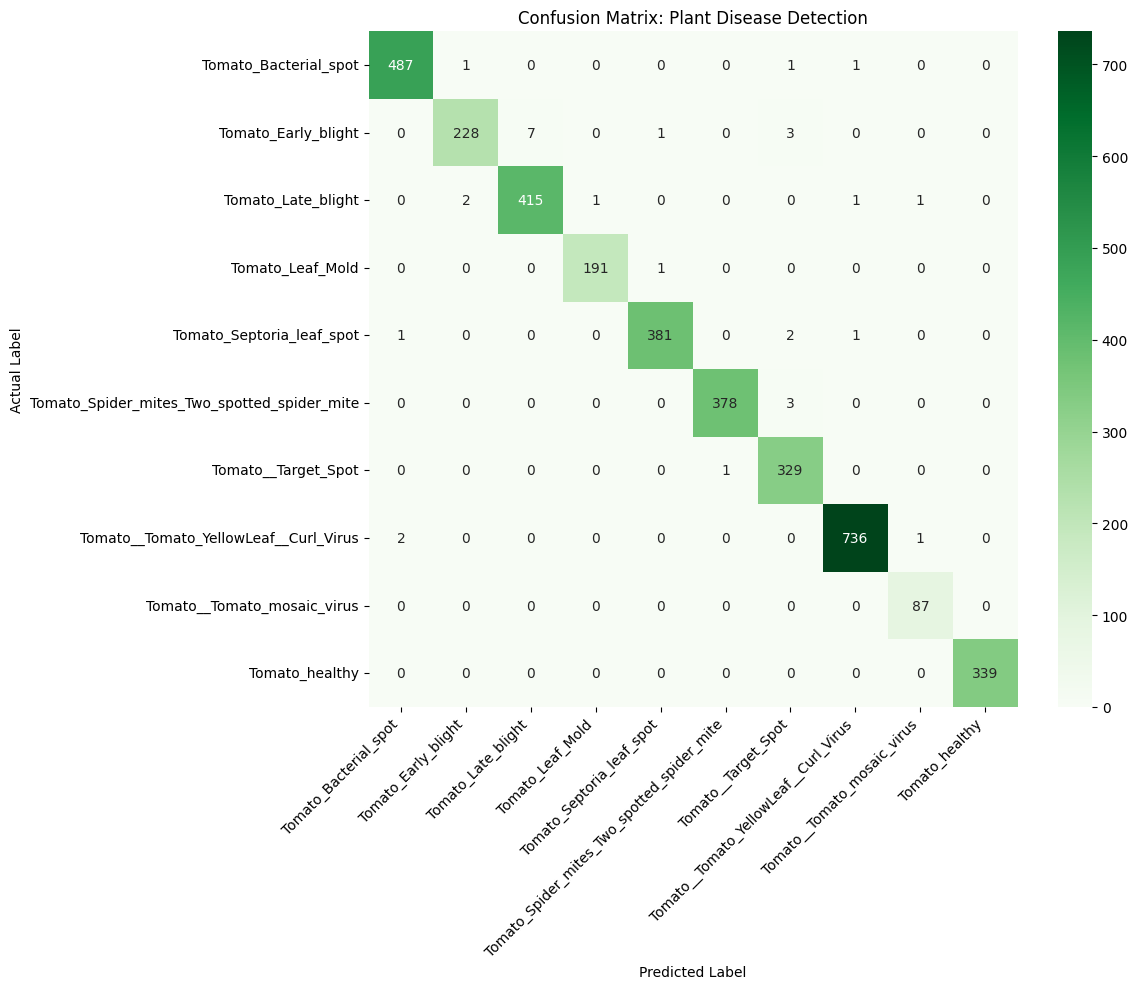

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score

model.load_state_dict(torch.load("best_model.pth"))
model.eval()

y_true = []
y_pred = []

print("Collecting predictions for metrics...")
with torch.no_grad():
    for images, labels in tqdm(val_loader):
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())


f1 = f1_score(y_true, y_pred, average='weighted')
print(f"\nOverall Weighted F1 Score: {f1:.4f}")

target_names = full_train_dataset.classes
print("\nDetailed Classification Report:")
print(classification_report(y_true, y_pred, target_names=target_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix: Plant Disease Detection')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()